In [20]:
import numpy as np
import pylab
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, TwoLocal, EfficientSU2, RealAmplitudes
from qiskit.circuit import Parameter
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP, SPSA
from qiskit_algorithms.utils import algorithm_globals

In [32]:
from qiskit.primitives import Estimator

estimator = Estimator()
algorithm_globals.random_seed = 50

In [21]:
H2_op = SparsePauliOp.from_list(
    [
        ("II", -1.0523),
        ("IZ", 0.3979),
        ("ZI", -0.3979),
        ("ZZ", -0.0113),
        ("XX", 0.1809),
    ]
)

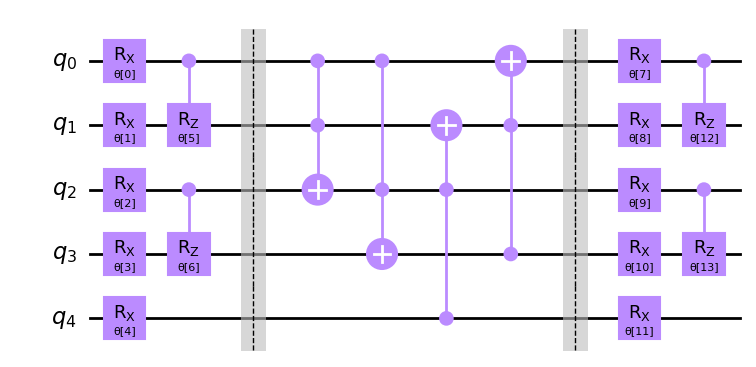

In [24]:
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=1,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

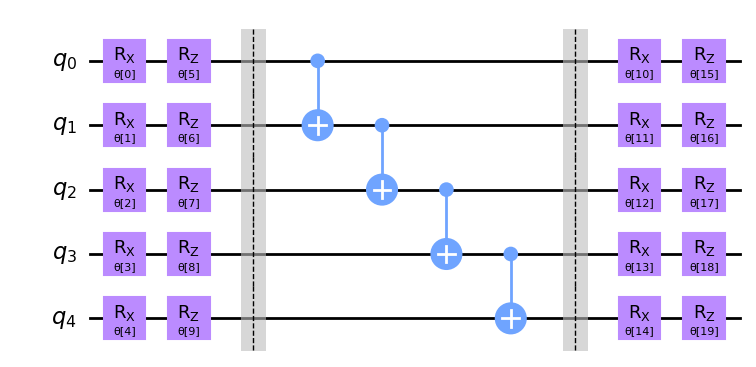

In [25]:
ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

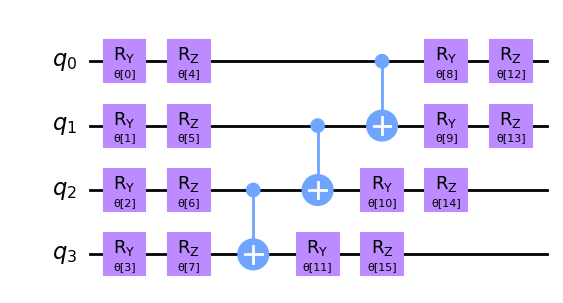

In [26]:
ansatz = EfficientSU2(4, reps = 1)
ansatz.decompose().draw("mpl")

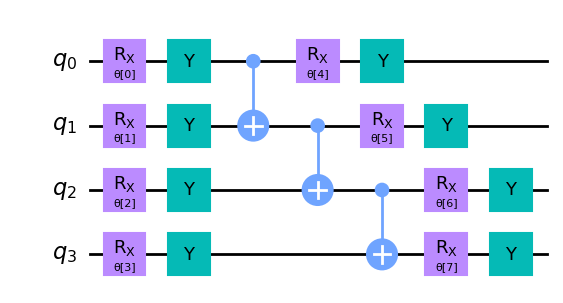

In [28]:
ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

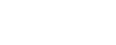

In [29]:
ansatz = RealAmplitudes(reps=1)
ansatz.decompose().draw("mpl")

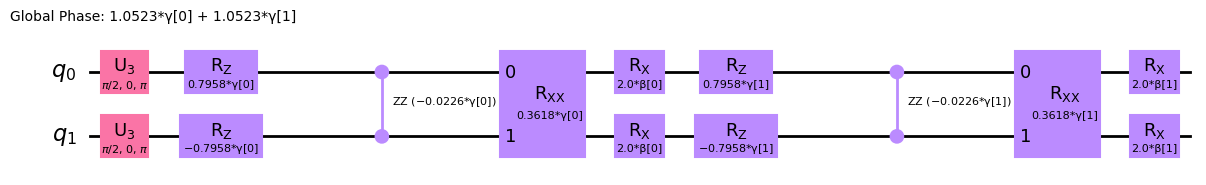

In [30]:
qaoa_ansatz = QAOAAnsatz(H2_op, reps=2)
qaoa_ansatz.decompose(reps=3).draw("mpl")

In [36]:
optimizers = [COBYLA(maxiter=100), L_BFGS_B(maxiter=100), SLSQP(maxiter=100), SPSA(maxiter=100)]
converge_counts = []
converge_vals = []

for optimizer in optimizers:
    ansatz = TwoLocal(rotation_blocks="ry", entanglement_blocks="cz")
    counts = []
    values = []

    def store_intermediate_result(eval_count, parameters, mean, std):
        counts.append(eval_count)
        values.append(mean)

    vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
    result = vqe.compute_minimum_eigenvalue(operator=H2_op)
    converge_counts.append(np.asarray(counts))
    converge_vals.append(np.asarray(values))

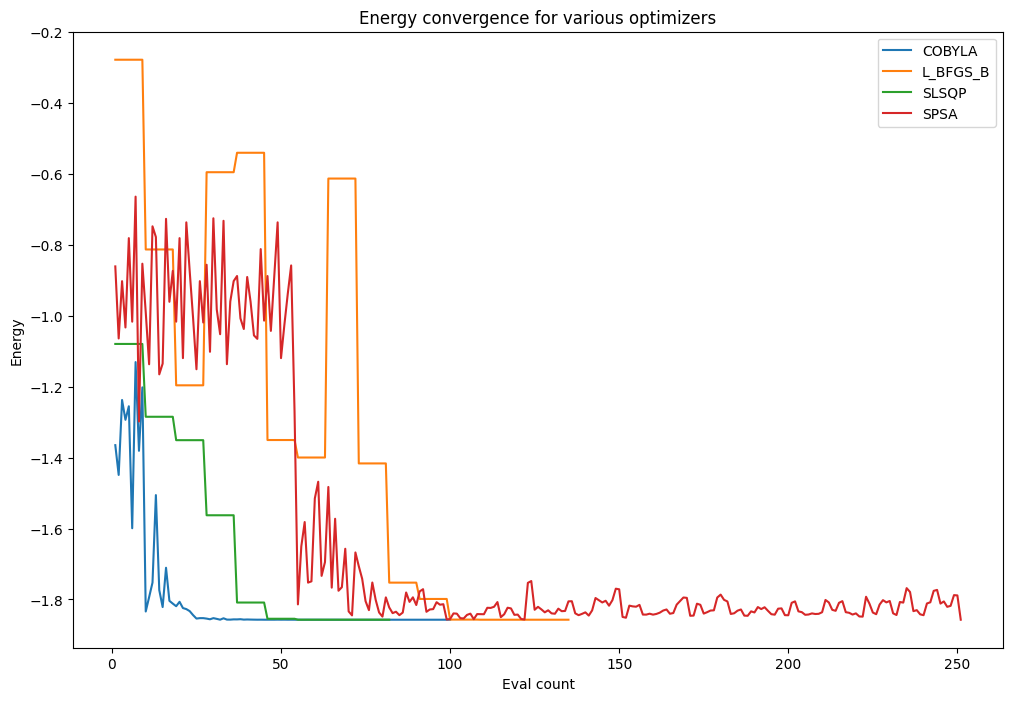

In [37]:
pylab.rcParams["figure.figsize"] = (12, 8)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_counts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel("Eval count")
pylab.ylabel("Energy")
pylab.title("Energy convergence for various optimizers")
pylab.legend(loc="upper right");

In [41]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit import execute, Aer
from qiskit.primitives import Sampler

# set classical optimizer
optimizer = COBYLA(maxiter=50)

# set variational ansatz
ansatz = RealAmplitudes(reps=1)

counts = []
values = []


def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)


# initialize VQE using CVaR with alpha = 0.1
# vqe = SamplingVQE(
#     Sampler(),
#     ansatz=ansatz,
#     optimizer=optimizer,
#     aggregation=0.1,
#     callback=store_intermediate_result,
# )
vqe = VQE(estimator, ansatz, optimizer, callback=store_intermediate_result)
raw_result = vqe.compute_minimum_eigenvalue(H2_op)
print(raw_result)

{   'aux_operators_evaluated': None,
    'cost_function_evals': 50,
    'eigenvalue': -1.8571006342106406,
    'optimal_circuit': <qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes object at 0x7f5c6da344c0>,
    'optimal_parameters': {   ParameterVectorElement(θ[3]): 2.0949102421850956,
                              ParameterVectorElement(θ[2]): -3.5059624543340413,
                              ParameterVectorElement(θ[1]): 4.144323210933576,
                              ParameterVectorElement(θ[0]): -0.4241445841818718},
    'optimal_point': array([-0.42414458,  4.14432321, -3.50596245,  2.09491024]),
    'optimal_value': -1.8571006342106406,
    'optimizer_evals': None,
    'optimizer_result': <qiskit.algorithms.optimizers.optimizer.OptimizerResult object at 0x7f5c6d6bfa00>,
    'optimizer_time': 0.5297346115112305}
